# Analisis de Sentimientos en reseñas de Steam.
**Victor M. Telles A.**
**25/03/2025**
**Programacion Mineria de datos**

## Descripcion
Este es un proyecto para practicar el procesamiento de lenguaje natural de los datos en donde esta enfocado para las reseñas de videojuegos de la API de Steam.

## Importacion de librerias


Aquí se importan las librerías esenciales para el procesamiento de lenguaje natural, análisis de datos y visualización. Utilizaremos nltk para el análisis de texto, pandas para la manipulación de dataframes, matplotlib y seaborn para graficar, y otras librerías como re y random para tareas específicas.

- `nltk` : Para el analisis de texto
- `pandas` : Para Para la manipulacion de dataframes
- `matplotlib y seaborn` : Para graficar
- `re` : Para expresiones regulares

In [3]:
# Importación de librerías para Procesamiento de Lenguaje Natural
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import random
import requests

from nltk.corpus import stopwords
from nltk import ngrams
from collections import Counter

# Descargar recursos de nltk, como stopwords
#nltk.download('punkt')
#nltk.download('stopwords')

# Confirmación de importación
print("Librerías importadas correctamente para el procesamiento de lenguaje natural.")

Librerías importadas correctamente para el procesamiento de lenguaje natural.


## Importacion de Datos de Steam
En esta parte se explica como obtener las reseñas de Steam. Se pueden extraer mediante la API de Steam, utilizando el siguiente endpoint:

`GET https://store.steampowered.com/appreviews/<id_de_aplicación>?json=1`
Se indican algunos parametros utiles como lo son:
- `filter`
- `language`
- `day_range`
- `cursor`
- `review_type`
- `num_per_page`
- `filter_offtopic_activity`

Para saber mas de los parametros puedes ir a [Steam API](https://partner.steamgames.com/doc/store/getreviews)

En esta parte se hace la peticion del endpoint mediante el `id del juego` con los parametros adecuados (En este caso, se extraen 100 reseñas por pagina en lenguaje de español).
La respuesta se presenta en estructura JSON devuelto y psoteriormente se carga en un DataFrame de *Pandas* para hacer el análisis

In [4]:
# URL de la API de Steam para obtener reseñas en español (100 reseñas)
id_game = "2246340"             # Monster Hunter Wilds = 2246340
language = "spanish"            # Idioma de las reseñas
num_per_page = "100"            # Número de reseñas por página
url = f"https://store.steampowered.com/appreviews/{id_game}?json=1&language={language}&num_per_page={num_per_page}"


# Realizar la solicitud a la API
response = requests.get(url)
data = response.json()

# Extraer las reseñas del JSON
reviews = data.get('reviews', [])

# Crear un DataFrame a partir de las reseñas
df_reviews = pd.DataFrame(reviews)

# Mostrar información básica del DataFrame
print("Información del DataFrame:")
print(df_reviews.info())


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   recommendationid             100 non-null    object
 1   author                       100 non-null    object
 2   language                     100 non-null    object
 3   review                       100 non-null    object
 4   timestamp_created            100 non-null    int64 
 5   timestamp_updated            100 non-null    int64 
 6   voted_up                     100 non-null    bool  
 7   votes_up                     100 non-null    int64 
 8   votes_funny                  100 non-null    int64 
 9   weighted_vote_score          100 non-null    object
 10  comment_count                100 non-null    int64 
 11  steam_purchase               100 non-null    bool  
 12  received_for_free            100 non-null    bool  
 13  written_d

In [5]:
# Mostar las primeras filas del DataFrame completo
print("\nPrimeras filas del DataFrame completo:")
df_reviews.head(5)


Primeras filas del DataFrame completo:


,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck
0,189321117,"{'steamid': '76561198138131071', 'num_games_ow...",spanish,"AMO el juego, es demasiado bueno y la verdad e...",1741064282,1741840734,False,135,6,0.832946836948394775,0,True,False,False,False
1,188940182,"{'steamid': '76561198049254557', 'num_games_ow...",spanish,Basta ya. Basta de sacar productos incompletos...,1740743526,1740743526,False,79,3,0.70836329460144043,0,True,False,False,False
2,189266847,"{'steamid': '76561198066270836', 'num_games_ow...",spanish,Uno de los mejores juegos de la historia sin d...,1741010357,1741010357,True,23,2,0.706308245658874512,1,True,False,False,False
3,189254007,"{'steamid': '76561198010057144', 'num_games_ow...",spanish,"As a Monster Hunter game, it's absolutely supe...",1740997022,1740997022,False,48,3,0.693980157375335693,5,True,False,False,False
4,188929055,"{'steamid': '76561198417230907', 'num_games_ow...",spanish,el juego de la banana esta mejor optimizado \n...,1740735215,1740751024,True,30,0,0.71985316276550293,0,True,False,False,False


In [6]:
# Prueba solo comentarios
# DataFrame para unicamente la columna de review y salga completamente el texto
df_reviewsComments = df_reviews[['review']]
df_reviewsComments.head(5)

,review
0,"AMO el juego, es demasiado bueno y la verdad e..."
1,Basta ya. Basta de sacar productos incompletos...
2,Uno de los mejores juegos de la historia sin d...
3,"As a Monster Hunter game, it's absolutely supe..."
4,el juego de la banana esta mejor optimizado \n...


## Limpieza de texto (Stopwords)
En esta seccion se muestra como limpiar el texto de las reseñas, removiendo stopwords en español para preparar el analisis. Se utilizan las stopwords de *nltk*


In [7]:
# Definir las stopwords en español
stop_words = set(stopwords.words('spanish'))

# Seleccionar una reseña aleatoria del DataFrame (Entre 0 y 99)
random_index = random.randint(0, min(99, len(df_reviews) - 1))
review = df_reviews['review'][random_index]

# Tokenizar la reseña (Minusculas) y limpiarla de signos de puntuación con stopwords y caracteres no alfabeticos
words = nltk.word_tokenize(review.lower(), language='spanish')      #Tokenizando la reseña
clean_words = [word for word in words if word not in stop_words and word.isalpha()]


print("Reseña original (Antes de hacer 'stopwords'):")
print(review)
print("\nReseña limpia (sin stopwords):")
print(" ".join(clean_words))

# Almacenar la reseña tokenizada y limpia en una nueva columna del DataFrame
#df_reviews['clean_review'] = df_reviews['review'].apply(lambda x: " ".join([word for word in nltk.word_tokenize(x.lower(), language='spanish') if word not in stop_words and word.isalpha()]))
df_reviews.loc[random_index, 'clean_review'] = " ".join(clean_words)


Reseña original (Antes de hacer 'stopwords'):
Bonito juego, Malisima Optimizacion, hay que jugar con muchos programas externos para siquiera estabilizarlo a 30fps con todo en alto a 2560x1650 o bajar mucho la resolucion para que sea estable. Muy mal , seria mejor que me devuelvan mi dinero, trate mil intentos para jugar de manera eficiente con una calidad desente pero es que es frustrante el imput lag y lo feo que se ve, Y nada es eso lo compre en playstation tambien para ver si hiba mejor y va de la mierda, No es posible que uno con tarjetas graficas de RTX 4070 no pueda correr este juego minimo a 30fps con graficos desente. No anden creando juegos con ese motor grafico que se va todo al carajo.

Reseña limpia (sin stopwords):
bonito juego malisima optimizacion jugar programas externos siquiera estabilizarlo alto bajar resolucion estable mal seria mejor devuelvan dinero trate mil intentos jugar manera eficiente calidad desente frustrante imput lag feo ve compre playstation tambien ver

## Tokenizacion
En esta seccion ilustra el proceso de tokenizacion, dividiendo el texto en palabras (tokens) para facilitar el analisis posterior


In [8]:
clean_review = df_reviews.loc[random_index, 'clean_review']

# Tokenización de una reseña (utilizando la misma reseña de ejemplo)
tokens = nltk.word_tokenize(clean_review, language='spanish')
print("Tokens de la reseña:")
print(tokens)


Tokens de la reseña:
['bonito', 'juego', 'malisima', 'optimizacion', 'jugar', 'programas', 'externos', 'siquiera', 'estabilizarlo', 'alto', 'bajar', 'resolucion', 'estable', 'mal', 'seria', 'mejor', 'devuelvan', 'dinero', 'trate', 'mil', 'intentos', 'jugar', 'manera', 'eficiente', 'calidad', 'desente', 'frustrante', 'imput', 'lag', 'feo', 've', 'compre', 'playstation', 'tambien', 'ver', 'si', 'hiba', 'mejor', 'va', 'mierda', 'posible', 'tarjetas', 'graficas', 'rtx', 'pueda', 'correr', 'juego', 'minimo', 'graficos', 'desente', 'anden', 'creando', 'juegos', 'motor', 'grafico', 'va', 'carajo']


## Obtener la reseña mas larga
A continuacion se extrae de las reseñas la que tenga mayor cantidad de caracteres o palabras.

In [9]:
# Calcular la longitud de cada reseña (por número de caracteres)
df_reviews['review_length'] = df_reviews['review'].apply(len)

# Seleccionar la reseña con mayor longitud
longest_review = df_reviews.loc[df_reviews['review_length'].idxmax()]['review']

print("La reseña más larga es:")
print(longest_review)


La reseña más larga es:
Gráficamente - es muy bello. apreciar los cambios en los biomas de abundante, sequía o el ambiente característico de la zona, ver como se desenvuelve en la zona los monstruos en ella. el como la fauna aporta en estos bellos lugares, lo juego en calidad media llegando a baja, la 3060 laptop no quiere mas. de rendimiento es raro puedo estar muy estable cazando pero entro a los campamentos y todo se arruina, se puede decir que va mas o menos. tengo que ser auto critico no puedo 
pedirle mucho a una laptop del 2021.

Historia - Me parece interesante el como se ingresa a el tema de las civilizaciones anteriores [spoiler] Sobretodo en las clonaciones y mejoras genéticas que lograron, o las forma de generar energía infinita mediante a un liquido [/spoiler]. pero la historia donde te conviertes en el pokemon del gremio o si lo ves de forma mas bonita el Alucard de integra Hellsing se 
siente raro, aunque eres lo maximo ya que nadie duda de que eres una maquina de matar,

## N-gramas
N-Gramas (Bi-Gramas, Tri-Gramas) a partir de las reseñas del videojuegos, para identificar secuencia frecuentes de palabras
Se utiliza la libreria de `from nltk import ngrams` para poder hacer los n-gramas

In [10]:
# Funcion para extraer n-gramas de una reseña
def get_ngrams(text, n=2):
    token = nltk.word_tokenize(text.lower(), language='spanish')
    return list(ngrams(token, n))

# Extraer n-gramas (Bi-gramas) de la reseña limpia
bigrams = get_ngrams(clean_review, n=2)
print(f"Bi-gramas de la reseña aleatoria:")
print(bigrams)


Bi-gramas de la reseña aleatoria:
[('bonito', 'juego'), ('juego', 'malisima'), ('malisima', 'optimizacion'), ('optimizacion', 'jugar'), ('jugar', 'programas'), ('programas', 'externos'), ('externos', 'siquiera'), ('siquiera', 'estabilizarlo'), ('estabilizarlo', 'alto'), ('alto', 'bajar'), ('bajar', 'resolucion'), ('resolucion', 'estable'), ('estable', 'mal'), ('mal', 'seria'), ('seria', 'mejor'), ('mejor', 'devuelvan'), ('devuelvan', 'dinero'), ('dinero', 'trate'), ('trate', 'mil'), ('mil', 'intentos'), ('intentos', 'jugar'), ('jugar', 'manera'), ('manera', 'eficiente'), ('eficiente', 'calidad'), ('calidad', 'desente'), ('desente', 'frustrante'), ('frustrante', 'imput'), ('imput', 'lag'), ('lag', 'feo'), ('feo', 've'), ('ve', 'compre'), ('compre', 'playstation'), ('playstation', 'tambien'), ('tambien', 'ver'), ('ver', 'si'), ('si', 'hiba'), ('hiba', 'mejor'), ('mejor', 'va'), ('va', 'mierda'), ('mierda', 'posible'), ('posible', 'tarjetas'), ('tarjetas', 'graficas'), ('graficas', 'rtx')

In [11]:
# Extraer n-gramas (Tri-gramas)
trigrams = get_ngrams(clean_review, n=3)
print(f"Tri-gramas de la reseña aleatoria:")
print(trigrams)

Tri-gramas de la reseña aleatoria:
[('bonito', 'juego', 'malisima'), ('juego', 'malisima', 'optimizacion'), ('malisima', 'optimizacion', 'jugar'), ('optimizacion', 'jugar', 'programas'), ('jugar', 'programas', 'externos'), ('programas', 'externos', 'siquiera'), ('externos', 'siquiera', 'estabilizarlo'), ('siquiera', 'estabilizarlo', 'alto'), ('estabilizarlo', 'alto', 'bajar'), ('alto', 'bajar', 'resolucion'), ('bajar', 'resolucion', 'estable'), ('resolucion', 'estable', 'mal'), ('estable', 'mal', 'seria'), ('mal', 'seria', 'mejor'), ('seria', 'mejor', 'devuelvan'), ('mejor', 'devuelvan', 'dinero'), ('devuelvan', 'dinero', 'trate'), ('dinero', 'trate', 'mil'), ('trate', 'mil', 'intentos'), ('mil', 'intentos', 'jugar'), ('intentos', 'jugar', 'manera'), ('jugar', 'manera', 'eficiente'), ('manera', 'eficiente', 'calidad'), ('eficiente', 'calidad', 'desente'), ('calidad', 'desente', 'frustrante'), ('desente', 'frustrante', 'imput'), ('frustrante', 'imput', 'lag'), ('imput', 'lag', 'feo'), (

In [12]:
# Extraer n-gramas (Cuatri-gramas)
cuatrigrams = get_ngrams(clean_review, n=4)
print(f"Cuatri-gramas de la reseña aleatoria:")
print(cuatrigrams)

Cuatri-gramas de la reseña aleatoria:
[('bonito', 'juego', 'malisima', 'optimizacion'), ('juego', 'malisima', 'optimizacion', 'jugar'), ('malisima', 'optimizacion', 'jugar', 'programas'), ('optimizacion', 'jugar', 'programas', 'externos'), ('jugar', 'programas', 'externos', 'siquiera'), ('programas', 'externos', 'siquiera', 'estabilizarlo'), ('externos', 'siquiera', 'estabilizarlo', 'alto'), ('siquiera', 'estabilizarlo', 'alto', 'bajar'), ('estabilizarlo', 'alto', 'bajar', 'resolucion'), ('alto', 'bajar', 'resolucion', 'estable'), ('bajar', 'resolucion', 'estable', 'mal'), ('resolucion', 'estable', 'mal', 'seria'), ('estable', 'mal', 'seria', 'mejor'), ('mal', 'seria', 'mejor', 'devuelvan'), ('seria', 'mejor', 'devuelvan', 'dinero'), ('mejor', 'devuelvan', 'dinero', 'trate'), ('devuelvan', 'dinero', 'trate', 'mil'), ('dinero', 'trate', 'mil', 'intentos'), ('trate', 'mil', 'intentos', 'jugar'), ('mil', 'intentos', 'jugar', 'manera'), ('intentos', 'jugar', 'manera', 'eficiente'), ('jugar

In [13]:
# Extraer n-gramas (Quitu-gramas)
quitugrams = get_ngrams(clean_review, n=5)
print(f"Quintu-gramas de la reseña aleatoria:")
print(quitugrams)

Quintu-gramas de la reseña aleatoria:
[('bonito', 'juego', 'malisima', 'optimizacion', 'jugar'), ('juego', 'malisima', 'optimizacion', 'jugar', 'programas'), ('malisima', 'optimizacion', 'jugar', 'programas', 'externos'), ('optimizacion', 'jugar', 'programas', 'externos', 'siquiera'), ('jugar', 'programas', 'externos', 'siquiera', 'estabilizarlo'), ('programas', 'externos', 'siquiera', 'estabilizarlo', 'alto'), ('externos', 'siquiera', 'estabilizarlo', 'alto', 'bajar'), ('siquiera', 'estabilizarlo', 'alto', 'bajar', 'resolucion'), ('estabilizarlo', 'alto', 'bajar', 'resolucion', 'estable'), ('alto', 'bajar', 'resolucion', 'estable', 'mal'), ('bajar', 'resolucion', 'estable', 'mal', 'seria'), ('resolucion', 'estable', 'mal', 'seria', 'mejor'), ('estable', 'mal', 'seria', 'mejor', 'devuelvan'), ('mal', 'seria', 'mejor', 'devuelvan', 'dinero'), ('seria', 'mejor', 'devuelvan', 'dinero', 'trate'), ('mejor', 'devuelvan', 'dinero', 'trate', 'mil'), ('devuelvan', 'dinero', 'trate', 'mil', 'int

## Expresiones Regulares
Utilizacion de expresiones regulares para buscar patrones especificos en las reseñas, o saber que tipos de palabras salen


In [14]:
pattern = r'\b[A-Z]{2,}\b'
matches = re.findall(pattern, clean_review)
print(f"Palabras en mayúsculas encontradas:")
print(matches)


Palabras en mayúsculas encontradas:
[]


## Graficos
Para esta seccion se mostrara una graficas, ya sea como por ejemplo de reseñas positivas vs negativas, palabras mas mencionada.


### Reseñas Positiva vs Negativas
Generar una grafica de pastel para generar la cantidad de reseñas positivas, negativas y neutrales.


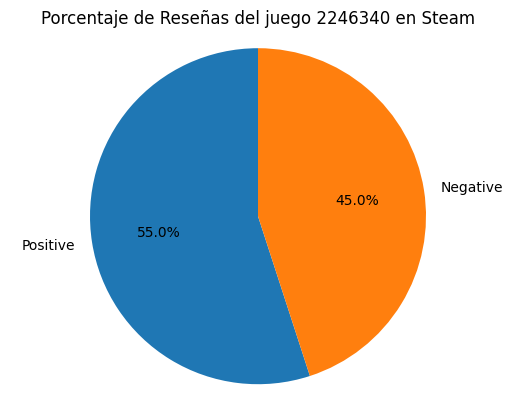

In [15]:
# Creando una columna 'sentiment' de forma simplificada basándonos en 'voted_up'
# (True -> 'Positive', False -> 'Negative')
df_reviews['sentiment'] = df_reviews['voted_up'].apply(lambda x: 'Positive' if x else 'Negative')

# Contar la cantidad de reseñas por sentimiento
sentiment_counts = df_reviews['sentiment'].value_counts()

# Graficar el resultado pero en pastel
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title(f"Porcentaje de Reseñas del juego {id_game} en Steam")
plt.show()



## Palabras mas y menos repetidas
Mostrar en grafico las palabras mas frecuentes y menos frecuentes.

Total de tokens: 5698


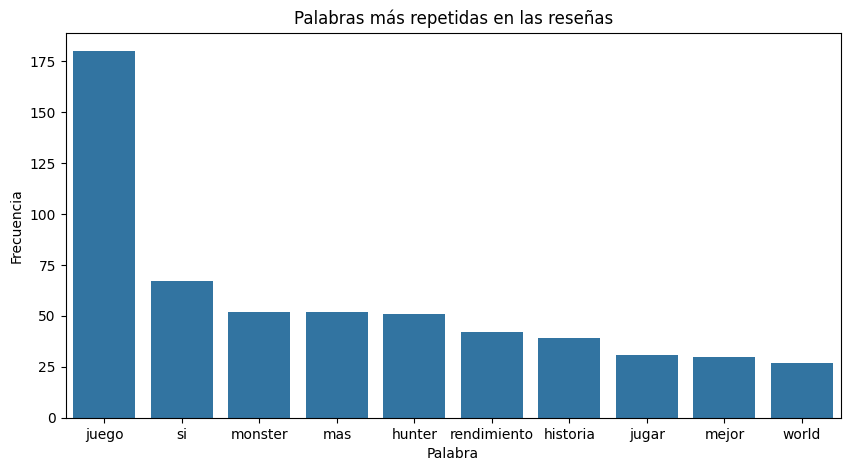

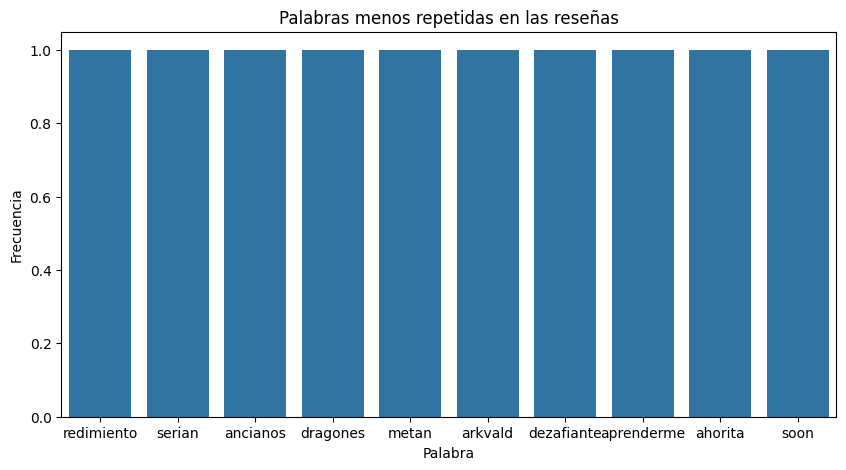

In [ ]:
# Juntar todas las reseñas en un solo texto limpio
all_reviews = " ".join(df_reviews['review'].tolist())
tokens_all = nltk.word_tokenize(all_reviews.lower(), language='spanish')
clean_tokens = [word for word in tokens_all if word not in stop_words and word.isalpha()]

# Contar la frecuencia de cada palabra
word_freq = Counter(clean_tokens)

# Seleccionar las 10 palabras más comunes
most_common_words = word_freq.most_common(10)
words, counts = zip(*most_common_words)

# Seleccionar las 10 palabras menos comunes
least_common_words = word_freq.most_common()[:-11:-1]
words_least, counts_least = zip(*least_common_words)

#Mostrar en consola cuantos tokens hay
print(f"Total de tokens analizados: {len(clean_tokens)}")

# Graficar las palabras más frecuentes
plt.figure(figsize=(10,5))
sns.barplot(x=list(words), y=list(counts))
plt.title("Palabras más repetidas en las reseñas")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")
plt.show()

# Graficar las palabras menos frecuentes
plt.figure(figsize=(10,5))
sns.barplot(x=list(words_least), y=list(counts_least))
plt.title("Palabras menos repetidas en las reseñas")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")
plt.show()

